In [1]:
# configuring the path of kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chod 600 ~/.kaggle/kaggle.json

/bin/bash: line 1: chod: command not found


In [2]:
!pip install opendatasets

In [3]:

import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition/data")

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition


In [4]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Reshape,MaxPooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
import os

paths = []
labels = []

# Define the root directory
root_dir = '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'

# Iterate through the subdirectories
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        # Add all files in the subdirectory
        for filename in os.listdir(subdir_path):
            file_path = os.path.join(subdir_path, filename)
            paths.append(file_path)
            # Add label based on the subdirectory name
            labels.append(subdir)

print('Dataset is loaded')

Dataset is loaded


In [6]:
len(paths)

64

In [7]:
paths[:5]

['/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav',
 '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/trump-original.wav',
 '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/ryan-original.wav',
 '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/linus-original.wav',
 '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/taylor-original.wav']

In [8]:
len(labels)

64

In [9]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels

In [10]:
df['label'].value_counts()

label
FAKE    56
REAL     8
Name: count, dtype: int64

In [28]:
audio_path = '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'
real_audio_path = 'REAL'
fake_audio_path = 'FAKE'

In [12]:
folders = os.listdir(audio_path)
print(folders)

['REAL', 'FAKE']


In [14]:
real_audio = '/content/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3'
fake_audio = '/content/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3'

In [15]:
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [16]:
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


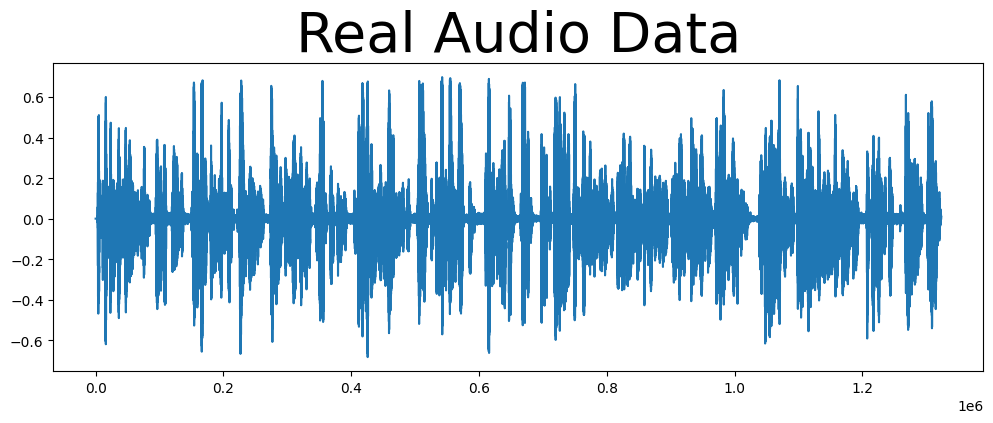

In [17]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize= (12,4))
plt.plot(real_ad)
plt.title('Real Audio Data',
          fontsize = 40)
plt.show()

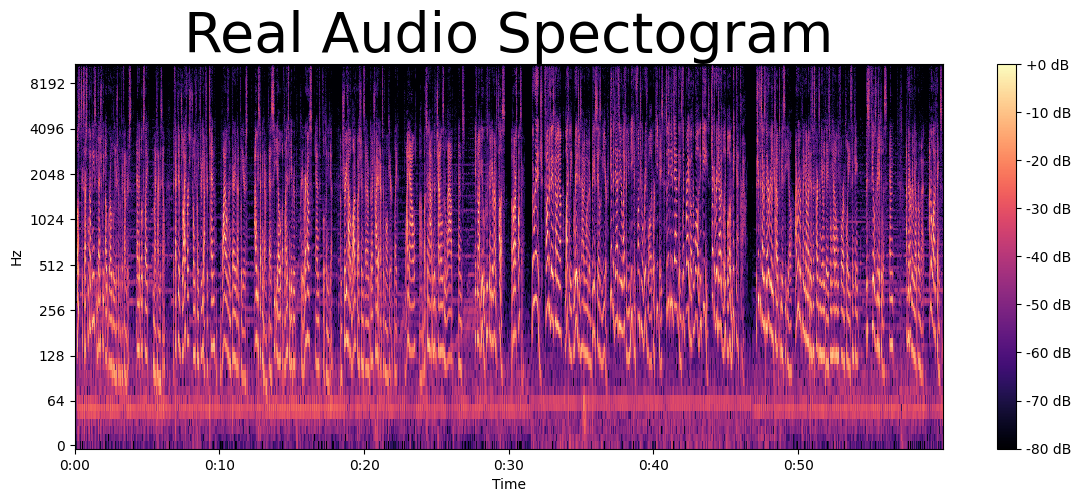

In [18]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(real_spec, sr = real_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Audio Spectogram",
          fontsize = 40)
plt.show()

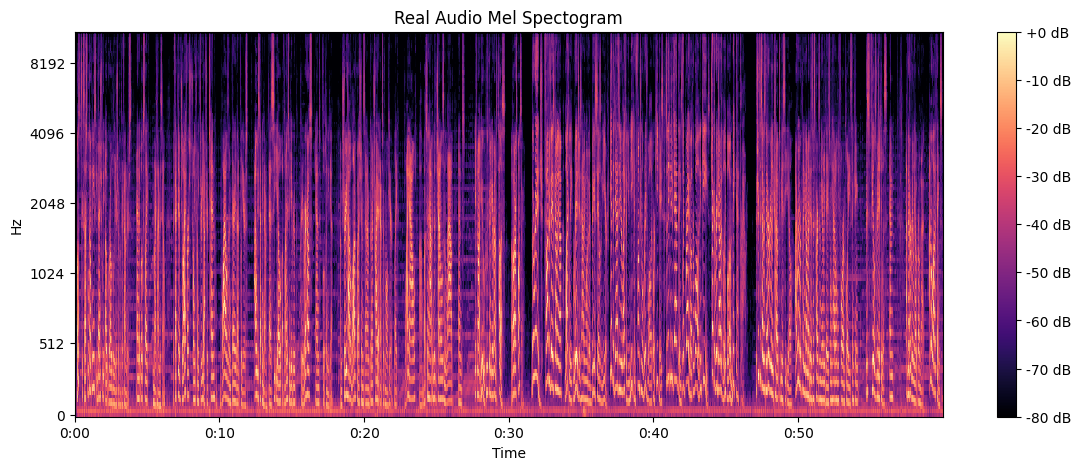

In [19]:
real_mel_spect = librosa.feature.melspectrogram(y = real_ad, sr = real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Real Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

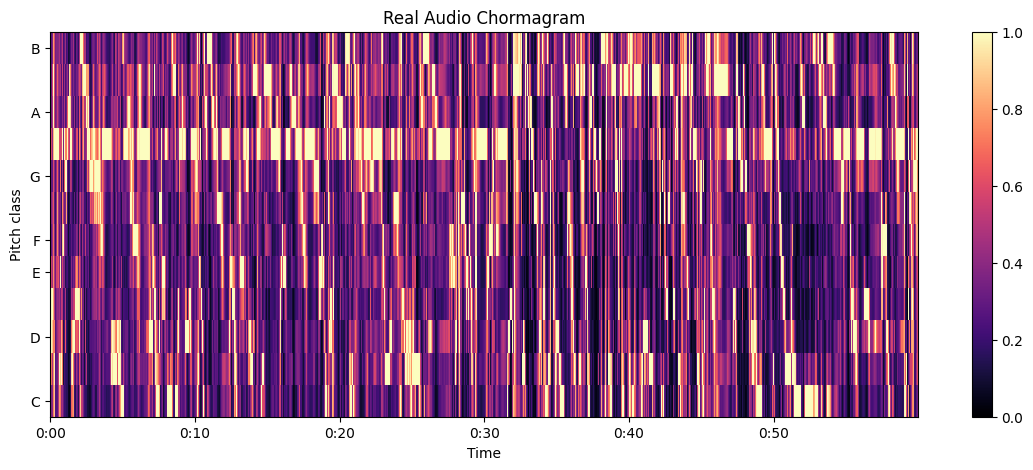

In [20]:
real_chroma = librosa.feature.chroma_cqt(y = real_ad, sr = real_sr, bins_per_octave=36)
plt.figure(figsize = (14, 5))
librosa.display.specshow(real_chroma, sr = real_sr, x_axis = 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Real Audio Chormagram')
plt.show()

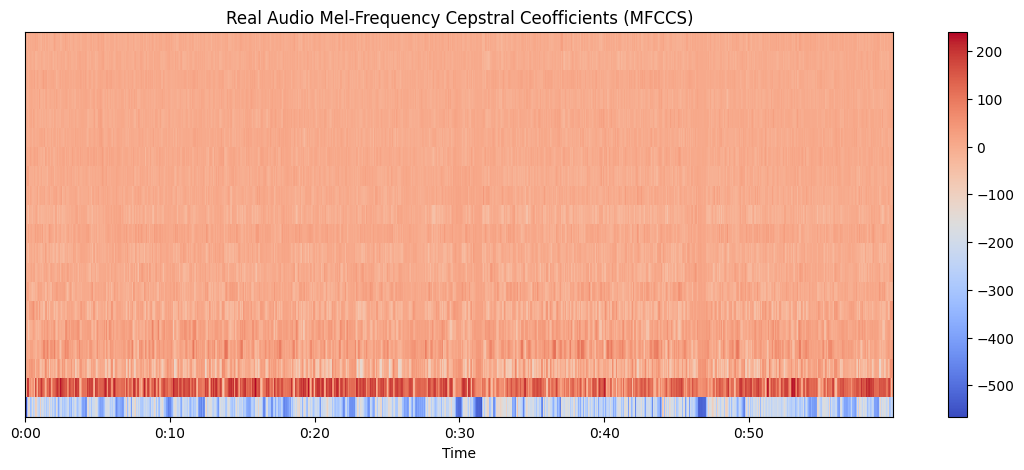

In [21]:
real_mfcc = librosa.feature.mfcc(y = real_ad, sr = real_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(real_mfcc, sr = real_sr, x_axis ='time')
plt.colorbar()
plt.title('Real Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

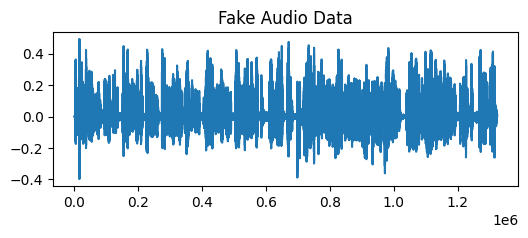

In [22]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize =(6,2))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

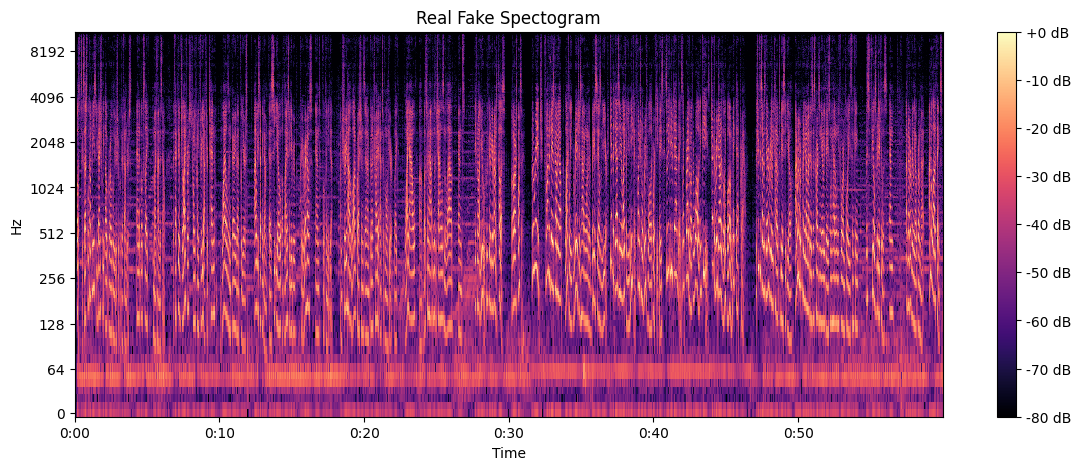

In [23]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref = np.max)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_spec, sr = fake_sr, x_axis = 'time', y_axis = 'log')
plt.colorbar(format = '%+2.0f dB')
plt.title("Real Fake Spectogram")
plt.show()

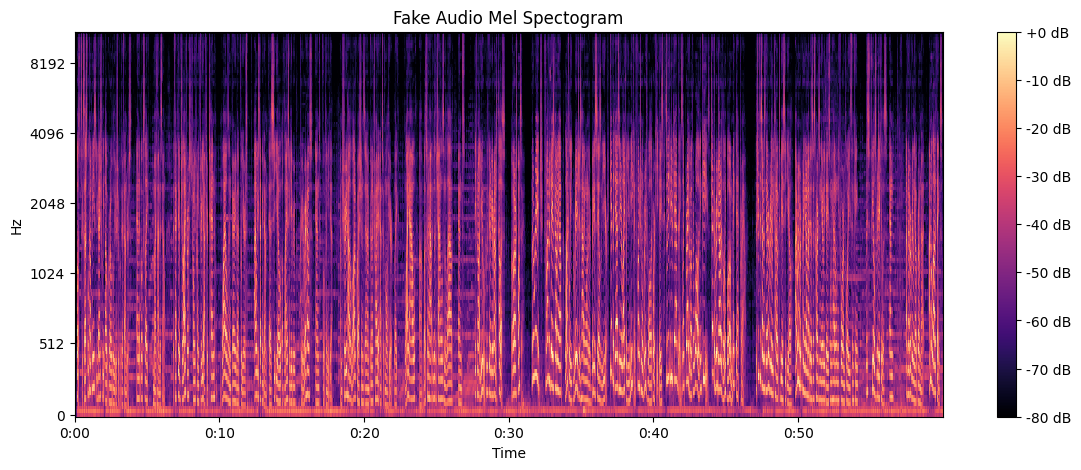

In [24]:
fake_mel_spect = librosa.feature.melspectrogram(y = fake_ad, sr = fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref = np.max)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mel_spect, y_axis ='mel', x_axis = 'time')
plt.title('Fake Audio Mel Spectogram')
plt.colorbar(format = '%+2.0f dB')
plt.show()

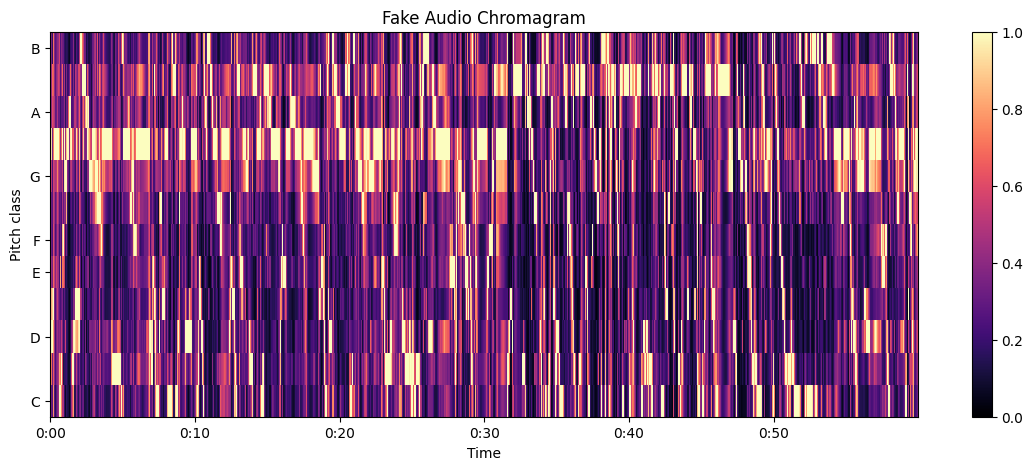

In [25]:
fake_chroma = librosa.feature.chroma_cqt(y = fake_ad, sr = fake_sr, bins_per_octave=36)
plt.figure(figsize=(14,5))
librosa.display.specshow(fake_chroma, sr = fake_sr, x_axis= 'time', y_axis = 'chroma', vmin = 0, vmax = 1)
plt.colorbar()
plt.title('Fake Audio Chromagram')
plt.show()

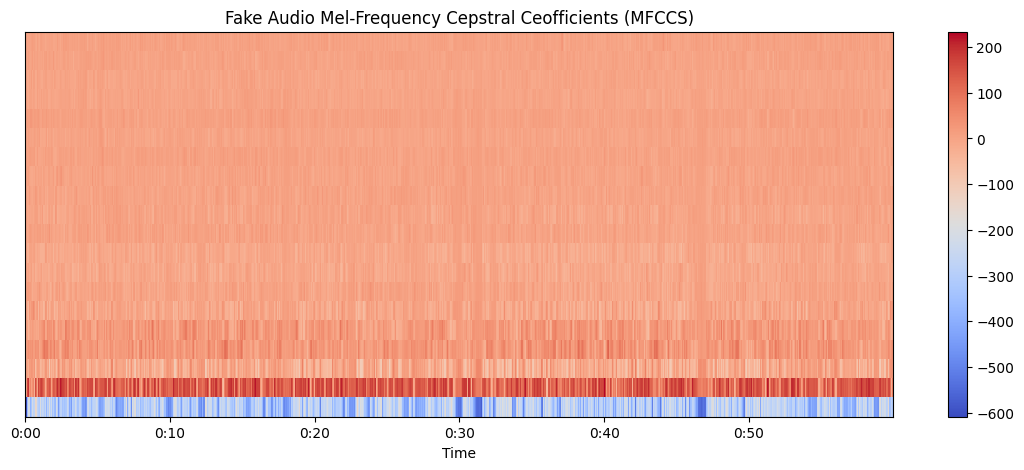

In [26]:
fake_mfcc = librosa.feature.mfcc(y = fake_ad, sr = fake_sr)
plt.figure(figsize = (14,5))
librosa.display.specshow(fake_mfcc, sr = fake_sr, x_axis ='time')
plt.colorbar()
plt.title('Fake Audio Mel-Frequency Cepstral Ceofficients (MFCCS)')
plt.show()

In [31]:
from tqdm import tqdm
import numpy as np
import os
import librosa

def extract_features(audio_path, max_length=500):
    features = []
    labels = []
    for folder in os.listdir(audio_path):
        folder_path = os.path.join(audio_path, folder)
        for file in tqdm(os.listdir(folder_path)):
            file_path = os.path.join(folder_path, file)
            try:
                # Load audio file
                audio, _ = librosa.load(file_path, sr=16000)
                # Extract features (example: using Mel-Frequency Cepstral Coefficients)
                mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=40)
                # Pad or trim the feature array to a fixed length
                if mfccs.shape[1] < max_length:
                    mfccs = np.pad(mfccs, ((0, 0), (0, max_length - mfccs.shape[1])), mode='constant')
                else:
                    mfccs = mfccs[:, :max_length]
                features.append(mfccs)
                # Assign label
                if folder == 'FAKE':
                    labels.append(1)  # 1 for fake
                else:
                    labels.append(0)  # 0 for real
            except Exception as e:
                print(f"Error encountered while parsing file: {file_path}")
                continue
    return np.array(features), np.array(labels)

# Example usage
# Change the audio_path to the correct path where the dataset is located
audio_path = '/content/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO' # Corrected path
x, y = extract_features(audio_path)

print("Features shape:", x.shape)
print("Labels shape:", y.shape)

100%|██████████| 56/56 [01:26<00:00,  1.55s/it]

Features shape: (64, 40, 500)
Labels shape: (64,)


In [32]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = .1)

In [33]:
model = Sequential([
    Reshape((40, 500, 1), input_shape=xtrain.shape[1:]),  # Reshape input to add channel dimension
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics  = ['accuracy'])

In [46]:

history = model.fit(
    xtrain, ytrain,
    epochs=200,
    batch_size=32,
    validation_data=(xtest, ytest)
)


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 1.0000 - loss: 3.3987e-05 - val_accuracy: 1.0000 - val_loss: 1.2972e-06
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.9098e-05 - val_accuracy: 1.0000 - val_loss: 1.2948e-06
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.4905e-06 - val_accuracy: 1.0000 - val_loss: 1.2942e-06
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.0106e-04 - val_accuracy: 1.0000 - val_loss: 1.2919e-06
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 7.2903e-05 - val_accuracy: 1.0000 - val_loss: 1.2541e-06
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 1.0000 - loss: 7.7435e-05 - val_accuracy: 1.0000 - val_loss: 1.1859e-06
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0388e-05 - val_accuracy: 1.0000 - val_loss: 1.0970e-06
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - acc

In [36]:
loss,accuracy = model.evaluate(xtest,ytest)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 3.0034e-05


In [37]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve

In [38]:
from sklearn.metrics import accuracy_score

ypred = np.round(model.predict(xtest))
val_acc = accuracy_score(ypred, ytest)

print(f"Accuracy: {val_acc*100: .2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
Accuracy:  100.00%


In [39]:
accuracy = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred)
recall = recall_score(ytest, ypred)
precision = precision_score(ytest, ypred)

In [40]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  1.0
F1 Score:  1.0
Recall:  1.0
Precision:  1.0


In [42]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


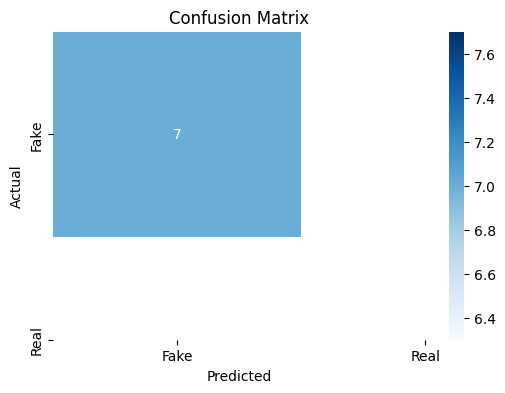

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# print confusion matrix
cm = confusion_matrix(ytest, ypred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

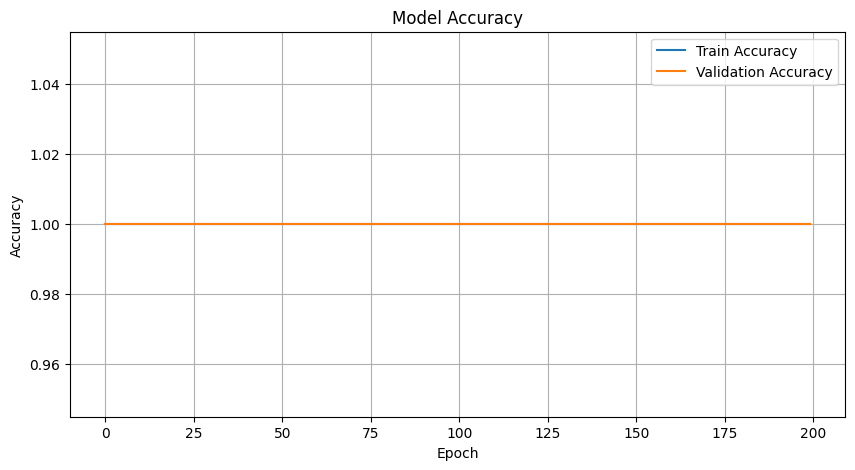

In [48]:
# Accuracy plot
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


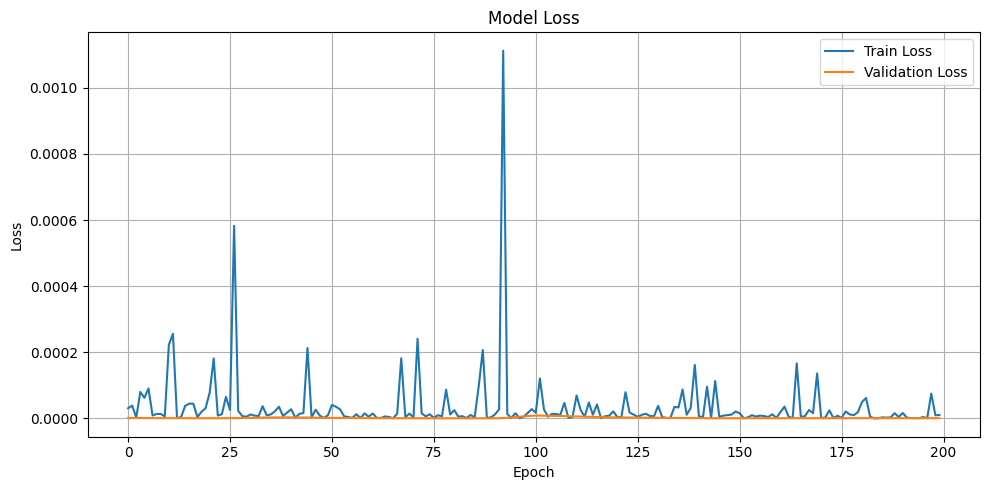

In [51]:
plt.figure(figsize=(10,5))
# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
